# COVID-19 OPEN RESEARCH DATASET

In [4]:
import os
import json
import pandas as pd

In [6]:
%cd '/home/myilmaz/devel/covid551982_1475446_bundle_archive/'

/home/myilmaz/devel/covid551982_1475446_bundle_archive


## Papers  researching chronic kidney disease as a comorbidity risk

In [8]:
kag=pd.read_csv('Kaggle/target_tables/8_risk_factors/Chronic kidney disease.csv')

In [9]:
kag.head()

,Unnamed: 0,Date,Study,Study Link,Journal,Severe,Severe lower bound,Severe upper bound,Severe p-value,Severe Significant,...,Fatality Significant,Fatality Adjusted,Fatality Calculated,Multivariate adjustment,Study Type,Sample Size,Study Population,Added on,Critical only,Discharged vs. death?
0,0,2020-06-01,Characteristics and Outcomes of COVID-19 Patie...,http://medrxiv.org/cgi/content/short/2020.05.2...,MedRxiv,NaN,NaN,NaN,NaN,NaN,...,Significant,Not Adjusted,Calculated,NaN,Retrospective observational study,13442,New York City Health and Hospital between Marc...,NaN,N,N
1,1,2020-05-31,Clinical Features and Short-term Outcomes of E...,https://www.sciencedirect.com/science/article/...,Int J Infect Dis,NaN,NaN,NaN,NaN,NaN,...,Significant,Not Adjusted,Extracted,NaN,Retrospective observational study,204,Renmin Hospital of Wuhan University from ...,NaN,N,N
2,2,2020-05-29,A clinical risk score to identify patients wit...,https://doi.org/10.1016/j.jinf.2020.05.064,J Infect,HR=0.90,0.54,1.51,0.7,Not Significant,...,Not Significant,Not Adjusted,Extracted,NaN,Retrospective observational study,1157,King’s College Hospital and Princess Royal Uni...,NaN,Y,N
3,3,2020-05-29,The Association Between Biomarkers and Clinica...,http://medrxiv.org/cgi/content/short/2020.05.2...,MedRxiv,NaN,NaN,NaN,NaN,NaN,...,Significant,Not Adjusted,Extracted,NaN,Retrospective observational study,299,299 patients with confirmed COVID-19 positive ...,NaN,Y,N
4,4,2020-05-29,Phenotypic characteristics and prognosis of in...,https://www.ncbi.nlm.nih.gov/pubmed/32472191/,Diabetologia,OR: 0.66,0.35,1.27,NaN,Not Significant,...,Not Significant,Not Adjusted,Extracted,NaN,Retrospective observational study,1317,The CORONADO study was launched in all French ...,NaN,Y,N


In [10]:
%ls document_parses

covid-Copy1.ipynb  covid.ipynb  pdf_json/  pmc_json/


In [11]:
keep=['Epidemiology, clinical course, and outcomes of critically ill adults with COVID-19 in New York City: a prospective cohort study']
arts=set(kag['Study'])-set(keep)

In [12]:
os.path.getsize('document_parses/pdf_json')/1000000

8.634368

## Filter papers that mention "creatinine" but are not listed as comorbidity risk papers

In [54]:
creat=[]
alltext=[]
for i in os.listdir('document_parses/pdf_json'):
    save=0
    savee=0

    with open('document_parses/pdf_json/'+i) as json_file:
        data = json.load(json_file)
        if data['metadata']['title'] not in list(arts):
        
            doc=[]
            text=''
            for c,j in enumerate(data['body_text']):
            
          
                row=[i,data['metadata']['title'],data['body_text'][c]['section'],c,data['body_text'][c]['text']]
                if data['body_text'][c]['text'].lower().find('creatinine')>-1:
                    save+=1
                if data['body_text'][c]['text'].lower().find('covid')>-1:
                    savee+=1
                if data['body_text'][c]['text'].lower().find('sars-cov-2')>-1:
                    savee+=1
                doc.append(row)
                text+=data['body_text'][c]['text']
            if save>0:
                if savee>0:
                    creat.append(doc)
                    alltext.append(text)
        else:
            pass

In [63]:
import numpy as np
np.min([len(i) for i in alltext])
np.max([len(i) for i in alltext])

print('Average document length is {} words'.format(np.mean([len(i) for i in alltext])))


Average document length is 31420.84946236559 words


In [64]:
jsons=[j[0] for i in creat for j in i]
titles=[j[1] for i in creat for j in i]
sections=[j[2] for i in creat for j in i]
sectionNo=[j[3] for i in creat for j in i]
text=[j[4] for i in creat for j in i]
creats=pd.DataFrame(None,columns=['jsons','titles','sections','sectionNo','text'])

In [65]:
creats=pd.DataFrame(None,columns=['jsons','titles','sections','sectionNo','text'])

In [66]:
creats.jsons=jsons
creats.titles=titles
creats.sections=sections
creats.sectionNo=sectionNo
creats.text=text

In [67]:
creats.head()

,jsons,titles,sections,text
0,fd4ccbdac4837e90209823ff38dbb82e58c51c3f.json,Journal Pre-proof Breastfeeding and Medication...,Introduction,Journal Pre-proof Breastfeeding and Medication...
1,fd4ccbdac4837e90209823ff38dbb82e58c51c3f.json,Journal Pre-proof Breastfeeding and Medication...,Introduction,Journal Pre-proof Breastfeeding and Medication...
2,fd4ccbdac4837e90209823ff38dbb82e58c51c3f.json,Journal Pre-proof Breastfeeding and Medication...,Introduction,Journal Pre-proof Breastfeeding and Medication...
3,fd4ccbdac4837e90209823ff38dbb82e58c51c3f.json,Journal Pre-proof Breastfeeding and Medication...,Mammary glands,Journal Pre-proof Breastfeeding and Medication...
4,fd4ccbdac4837e90209823ff38dbb82e58c51c3f.json,Journal Pre-proof Breastfeeding and Medication...,Mammary glands,Journal Pre-proof Breastfeeding and Medication...


In [68]:
docs=creats.copy# NUMBER OF UNIQUE DOCUMENTS IN THE DATA SET
docs['jsons'].nunique()(deep=True)

In [69]:
docs.drop_duplicates(keep='first',inplace=True)

In [70]:
# NUMBER OF UNIQUE DOCUMENTS IN THE DATA SET
docs['jsons'].nunique()

1581

In [71]:
docs.to_csv('covid.csv')

In [ ]:
#START HERE

In [72]:
docs=pd.read_csv('covids.csv')

## Use pretrained NER model to find Problems, Tests, and Treatments

In [73]:
import os


import pyspark.sql.functions as F
from pyspark.sql.functions import monotonically_increasing_id
import json
import os
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession


from sparknlp.annotator import *

from sparknlp.base import *

# Install pyspark
! pip install --ignore-installed -q pyspark==2.4.4


# Install Spark NLP
! pip install --ignore-installed -q spark-nlp==2.5


import sparknlp

print (sparknlp.version())

import json
import os
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from sparknlp.annotator import *

from sparknlp.base import *

from pyspark.sql.functions import monotonically_increasing_id
import pyspark.sql.functions as F
import pyspark.sql.types as t




You should consider upgrading via the '/home/myilmaz/devel/mag/notebooks/3.7env/bin/python -m pip install --upgrade pip' command.
ERROR: spark-nlp-jsl 2.5.4rc4 has requirement spark-nlp==2.5.4, but you'll have spark-nlp 2.5.0 which is incompatible.
You should consider upgrading via the '/home/myilmaz/devel/mag/notebooks/3.7env/bin/python -m pip install --upgrade pip' command.
2.5.0


In [74]:
spark=sparknlp.start()

In [75]:
docs.fillna('',inplace=True)

In [76]:
docs.head(1)

,Unnamed: 0,jsons,titles,sections,text
0,0,fd4ccbdac4837e90209823ff38dbb82e58c51c3f.json,Journal Pre-proof Breastfeeding and Medication...,Introduction,Journal Pre-proof Breastfeeding and Medication...


In [77]:
sparkdocs=spark.createDataFrame(docs).toDF('index','docid','title','section','sectionNo','text')

In [78]:
document_assembler = DocumentAssembler() \
        .setInputCol("text")\
        .setOutputCol('document')
    
sentence_detector = SentenceDetector() \
        .setInputCols(["document"]) \
        .setOutputCol("sentence")

tokenizer = Tokenizer() \
        .setInputCols(["sentence"]) \
        .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.load("/home/myilmaz/cache_pretrained/embeddings_clinical_en_2.4.0_2.4_1580237286004")\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("embeddings")
clinical_ner = NerDLModel.load('/home/myilmaz/cache_pretrained/ner_clinical_en_2.4.0_2.4_1580237286004') \
        .setInputCols(["sentence", "token", "embeddings"]) \
        .setOutputCol("ner")
ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")
nlpPipeline = Pipeline(stages=[document_assembler,sentence_detector,tokenizer,
    word_embeddings,
    clinical_ner,ner_converter
    ])


empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)


In [79]:
results=model.transform(sparkdocs)

In [80]:
results.columns

['index',
 'docid',
 'title',
 'section',
 'text',
 'document',
 'sentence',
 'token',
 'embeddings',
 'ner',
 'ner_chunk']

In [81]:
exploded = results.select('docid','title','section','sectionNo',F.explode(F.arrays_zip('token.metadata','token.result','ner.result')).alias("cols")) \
        .select('docid','title','section','sectionNo',F.expr("cols['0'].sentence").alias("sentid"),
        F.col('cols.1').alias("token"),F.col('cols.2').alias("label"))

## Save annotated documents for further analysis

In [ ]:
exploded.write.option("header", "true").csv("covid2.csv")

In [5]:
os.listdir('covid2.csv')[0]

'part-00002-c113f676-f5af-45d7-96c9-4dcb22a31a90-c000.csv'

In [6]:
import pyspark.sql.types as t
myschema = t.StructType(
   [
    t.StructField('docid', t.StringType(), True),
    t.StructField('title', t.StringType(), True),
    t.StructField('section', t.StringType(), True),
    t.StructField('sectionNo', t.StringType(), True),
    t.StructField('sentid', t.IntegerType(), True),
    t.StructField('token', t.StringType(), True),
    t.StructField('label', t.StringType(), True)

   ]
  )

In [7]:
csvs=os.listdir('covid2.csv')
big=pd.DataFrame(None)
for i in csvs:
    
    dfs=spark.read.csv('covid2.csv/'+i,sep=',',schema=myschema,header=True)
    one=dfs.toPandas()
    big=big.append(one)

In [8]:
big.head()

,docid,section,sentid,token,label
0,60a80d5b8f7f2066e38b0877371eeccfc6927ac0.json,Results,0,Health-exploring,O
1,60a80d5b8f7f2066e38b0877371eeccfc6927ac0.json,Results,0,complexity,O
2,60a80d5b8f7f2066e38b0877371eeccfc6927ac0.json,Results,0,:,O
3,60a80d5b8f7f2066e38b0877371eeccfc6927ac0.json,Results,0,an,O
4,60a80d5b8f7f2066e38b0877371eeccfc6927ac0.json,Results,0,interdisciplinary,O


In [9]:
import numpy as np

tokens=[]
savei=''
save=0
for i,j in zip(big.token,big.label):
    if j.split('-')[0]!='I':
        if save<0:
            tokens[save]=savei
            tokens.append(np.nan)
            savei=i
            save=0
            continue
        else:
            tokens.append(savei)
            savei=i
            save=0
            continue
    elif j.split('-')[0]=='I':
        savei+=' '+i
        save-=1
        tokens.append(np.nan)
    else:
        tokens.append(np.nan)

               
if save<0:
    tokens[save]=savei
    tokens.append(np.nan)
else:
    tokens.append(savei) 
    
tokens=tokens[1:]
        

In [10]:
big['chunks']=tokens

In [11]:
bigdf=big[big['chunks'].notnull()]

In [12]:
bigdf=bigdf[bigdf['label']!='O']

In [13]:
bigdf['chunks'].value_counts()

SARS-CoV-2                  6520
treatment                   4076
this study                  3871
SARS-CoV-2 infection        2809
death                       2791
                            ... 
complex tumor                  1
cytoplasmic DNA receptor       1
the related SARS-CoV-1         1
D-dimer elevations             1
postsurge                      1
Name: chunks, Length: 383825, dtype: int64

## Prep for visualizations

In [14]:
problems=bigdf[bigdf['label']=='B-PROBLEM']

In [15]:
tests=bigdf[bigdf['label']=='B-TEST']

In [46]:
len(problems[problems['chunks']=='proteinuria'])

259

In [16]:
probhist=pd.DataFrame(problems['chunks'].value_counts())
probhist=probhist.rename(columns={'chunks':'counts'})
probhist2=probhist.iloc[0:100]

In [17]:
testhist=pd.DataFrame(tests['chunks'].value_counts())
testhist=testhist.rename(columns={'chunks':'counts'})
testhist2=testhist.iloc[0:100]

## Look at most frequent "Test" entities

In [18]:
testhist2.head(40)

,counts
this study,3869
the study,2771
our study,1613
CI,1557
CRP,1518
A,1509
data,1359
studies,1301
This study,1210
creatinine,1127


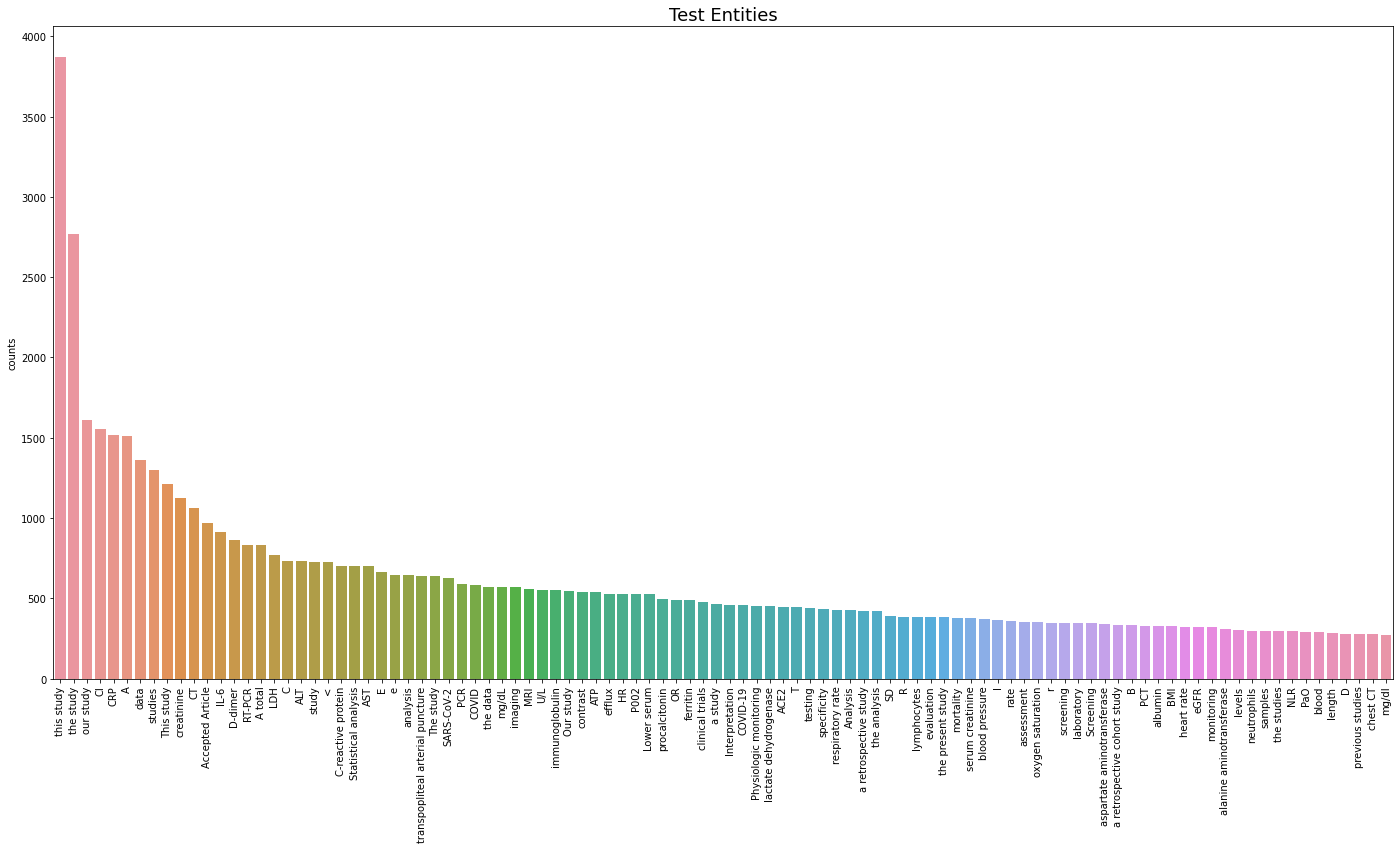

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize =(24,12))
chart=sns.barplot(testhist2.index,testhist2['counts'])
chart.set_xticklabels(testhist2.index,rotation=90)
plt.title('Test Entities',fontsize=18)
plt.show()

The pretrained model is returning a lot of false positive for Test entities, but you can still see that kidney related tests such as "creatinine" are well represented in the dataset.

## Look at most frequent "Problem" entities

In [20]:
probhist2.head(40)

,counts
SARS-CoV-2,4863
SARS-CoV-2 infection,2807
death,2758
AKI,2505
in-stent stenosis,2331
hypertension,2254
diabetes,2184
fever,2182
ARDS,2014
infection,1900


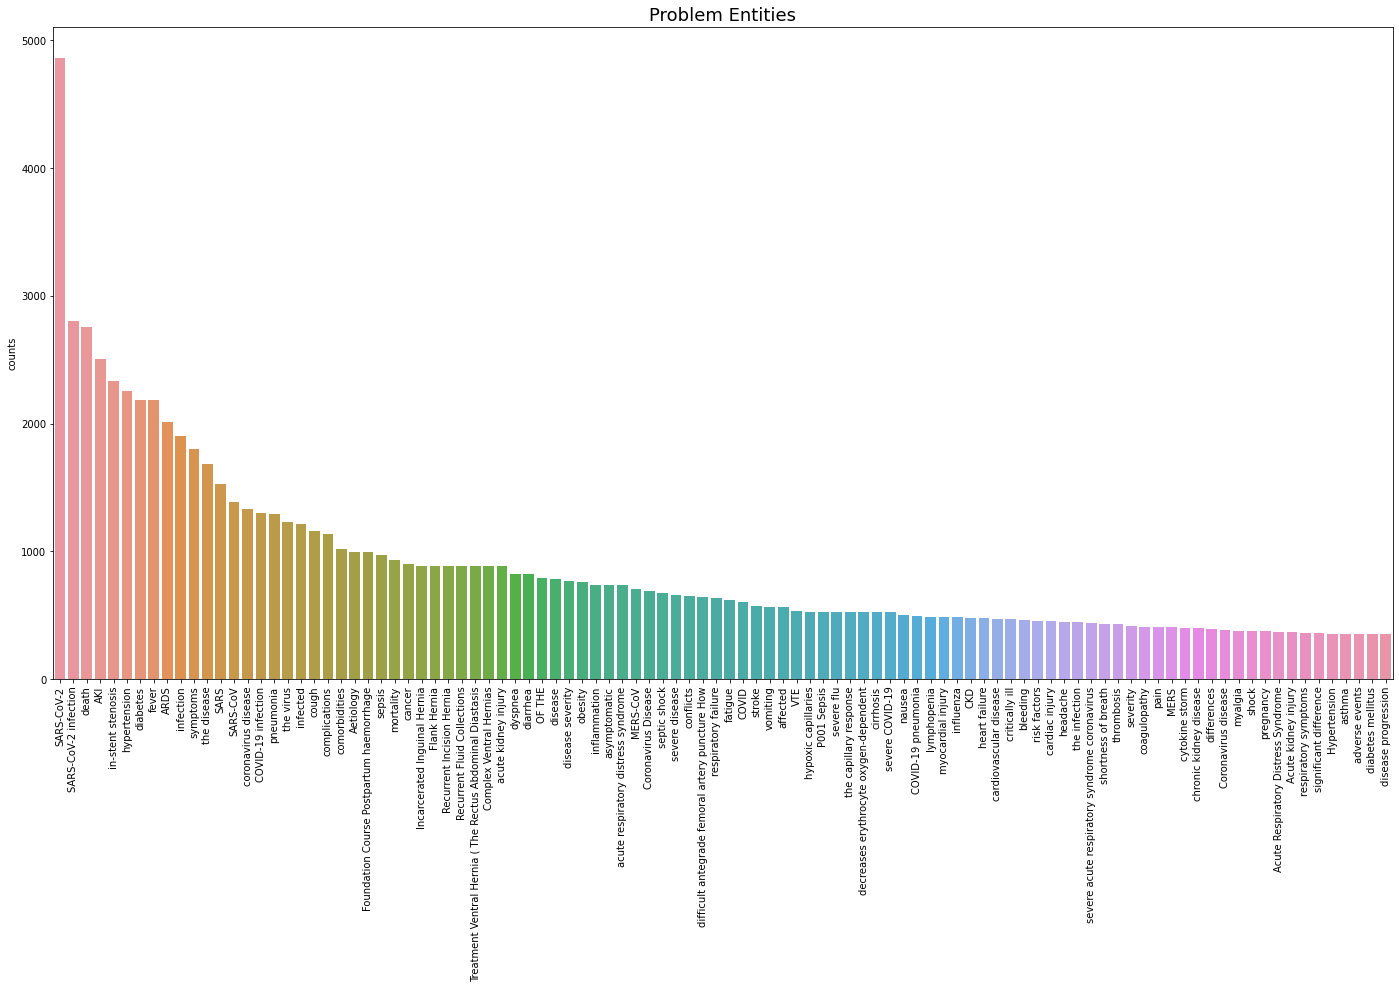

In [21]:
import seaborn as sns
import seaborn as sns
fig, ax = plt.subplots(figsize =(24,12))
chart=sns.barplot(probhist2.index,probhist2['counts'])
chart.set_xticklabels(probhist2.index,rotation=90)
plt.title('Problem Entities',fontsize=18)
plt.show()

You can see that kidney related problems such as "AKI" are well represented in the dataset.

## Find 'Test' entities near the most frequent kidney related 'Problem' entity

In [22]:
problems=pd.DataFrame(problems).reset_index(drop=True)
problems['sectionid']=problems.docid+'-'+problems.section

In [23]:
tests=pd.DataFrame(tests).reset_index(drop=True)
tests['sectionid']=tests.docid+'-'+tests.section

In [24]:
akis=pd.DataFrame(problems[problems['chunks']=='AKI']).reset_index(drop=True)

In [25]:
a=list(set(akis['sectionid']))

In [26]:
akitest=tests[tests['sectionid'].isin(a)]

In [27]:
akicount=pd.DataFrame(akitest.groupby(['chunks'])['label'].count()).reset_index()

akicount=akicount.sort_values(by='label',ascending=False).reset_index(drop=True)
akicount.columns=['chunk','counts']

In [28]:
akicount

,chunk,counts
0,this study,415
1,CI,329
2,the study,231
3,immunoglobulin,214
4,P002,212
...,...,...
14465,Whole slide imaging,1
14466,Wilcoxon Rank sum test,1
14467,Wilcoxon Ranksum,1
14468,Wilcoxon rank-sum tests,1


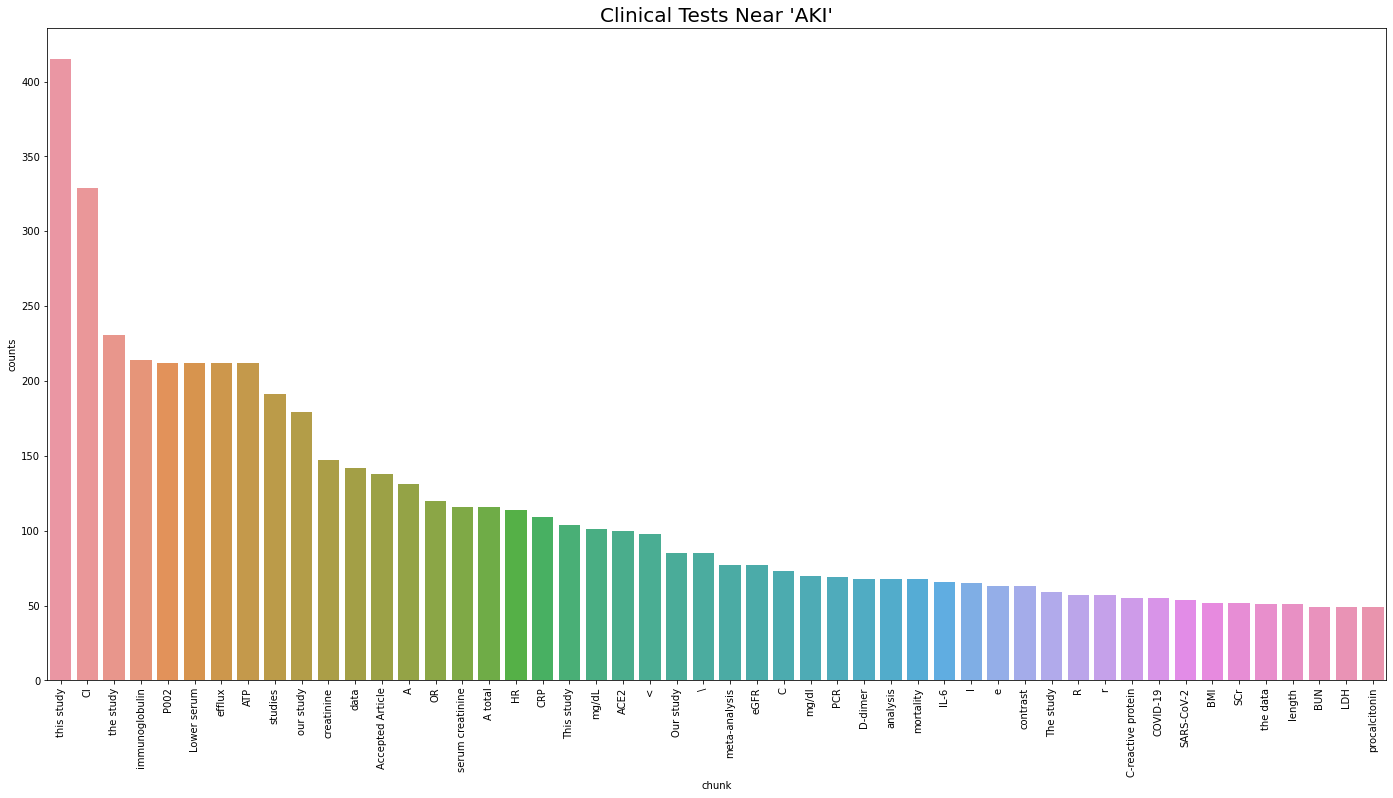

In [29]:
import seaborn as sns
import seaborn as sns
fig, ax = plt.subplots(figsize =(24,12))
chart= sns.barplot(akicount['chunk'][0:50],akicount['counts'][0:50])

chart.set_xticklabels(akicount.chunk,rotation=90)
plt.title("Clinical Tests Near 'AKI'",fontsize=20)


plt.show()

Our clinical tests NER is returning a lot of false positives but we still see that creatinine, CRP, and PCR tests  are well represented in the dataset, appearing in the same section as "AKI". This tells me the information is probably not historical and I will have measurements that I can use for predictions as well as terms to use for topic modelling and text classification.

## Find 'Problem' entities near the most frequent kidney related 'Test' entity

In [30]:
creatins=pd.DataFrame(tests[tests['chunks']=='creatinine']).reset_index(drop=True)
b=list(set(creatins['sectionid']))
creatprob=problems[problems['sectionid'].isin(b)]
creatcount=pd.DataFrame(creatprob.groupby(['chunks'])['label'].count()).reset_index()

creatcount=creatcount.sort_values(by='label',ascending=False).reset_index(drop=True)
creatcount.columns=['chunk','counts']

In [42]:
creatcount

,chunk,counts
0,SARS-CoV-2,550
1,in-stent stenosis,500
2,AKI,435
3,fever,405
4,hypertension,373
...,...,...
30265,chronic HCV infection,1
30266,chronic HCV,1
30267,chronic,1
30268,chromosomal deletions,1


In [31]:
creatcounts=creatcount.iloc[0:50]

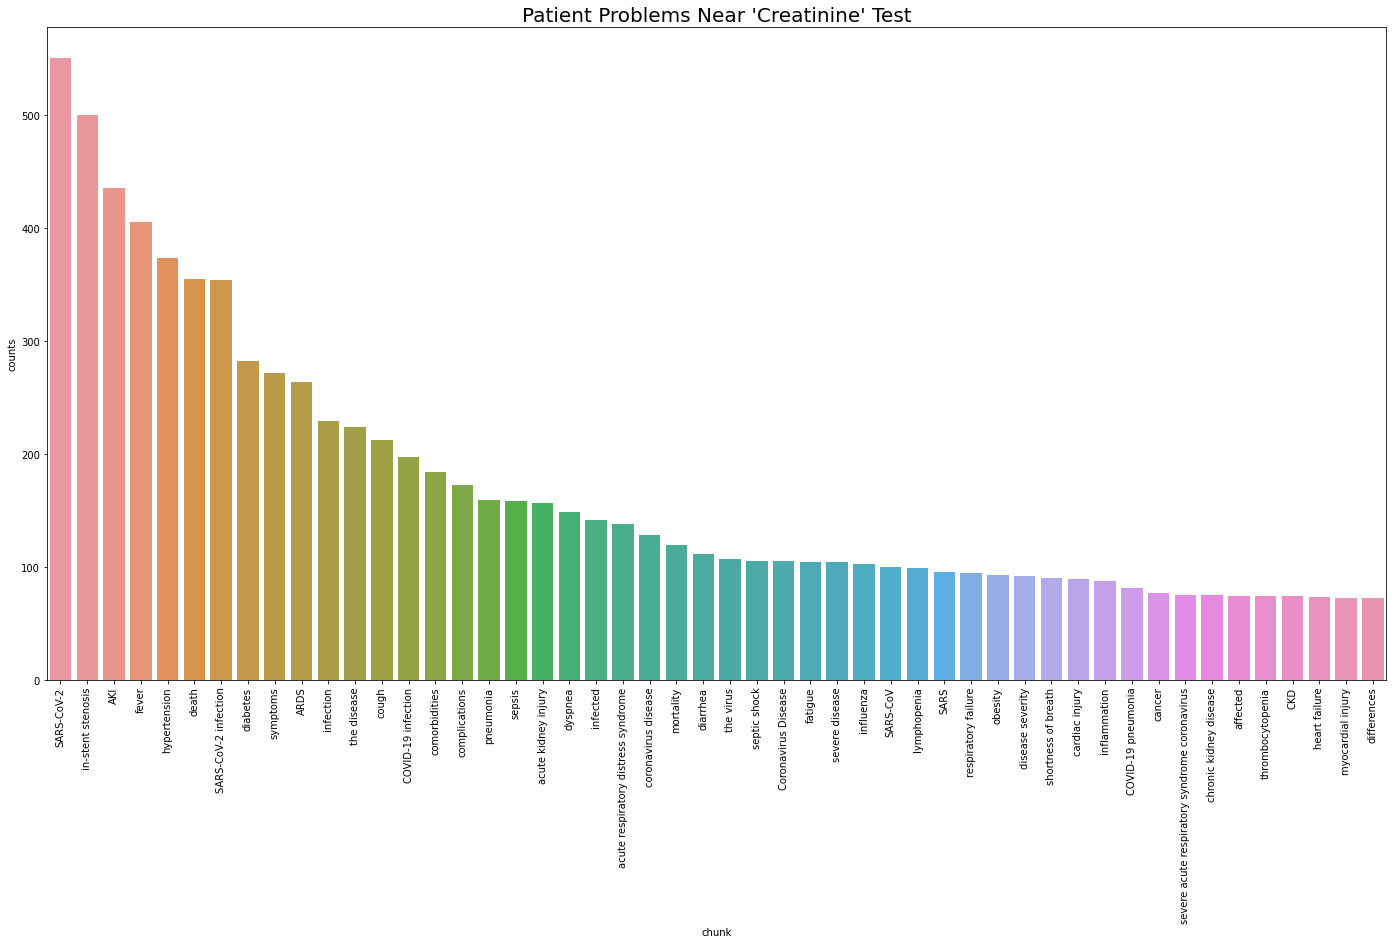

In [32]:
import seaborn as sns
import seaborn as sns
fig, ax = plt.subplots(figsize =(24,12))
chart= sns.barplot(creatcounts.chunk,creatcounts['counts'])

chart.set_xticklabels(creatcounts.chunk,rotation=90)
plt.title("Patient Problems Near 'Creatinine' Test",fontsize=20)


plt.show()

AKI, hypertension, diabetes, and acute kidney injury are all well represented in the dataset, appearing in the same section as "creatinine" tests. This tells me the information is probably not historical and I will have measurements that I can use for predictions as well as terms to use for topic modelling and text classification.

## Frequency of 'patient' mentions in documents

In [33]:
patient=pd.DataFrame(big[(big['token'].str.lower()=='patient')|(big['token'].str.lower()=='patients')]).reset_index(drop=True)

In [35]:
patients=patient.groupby(['docid'])['token'].count()
patients=patients.reset_index()
patients=patients.rename(columns={'token':'counts'})
len(patients)

1568

Text(0.5, 1.0, 'Frequency of Patient Mentions in 1568 Documents')

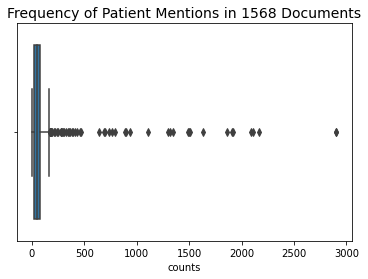

In [41]:
sns.boxplot(patients['counts'])
plt.title('Frequency of Patient Mentions in 1568 Documents',fontsize=14)

## Frequency of 'case report' mentions in documents

In [37]:
case=pd.DataFrame(big[(big['section'].str.lower()=='case report')|(big['section']=='case study')|(big['chunks'].str.lower()=='case report')|(big['chunks'].str.lower()=='case study')|(big['section'].str.lower()=='case reports')|(big['section']=='case studies')|(big['chunks'].str.lower()=='case reports')|(big['chunks'].str.lower()=='case studies')]).reset_index(drop=True)

In [38]:
cases=case.groupby(['docid'])['section'].count()
cases=cases.reset_index()
cases=cases.rename(columns={'section':'counts'})
len(cases)

78

Text(0.5, 1.0, 'Frequency of Case Report/Study Mentions in 78 Documents')

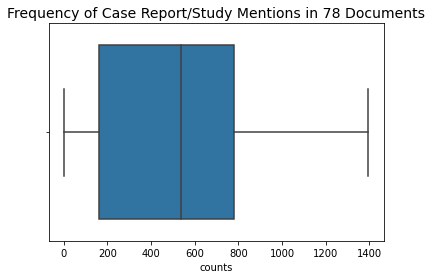

In [40]:
sns.boxplot(cases['counts'])
plt.title('Frequency of Case Report/Study Mentions in 78 Documents',fontsize=14)

78 documents refer to case reports a median of about 550 times (The average document length is about 30,000 words.) I think I will have enough patient data to attempt some predictions.

In [14]:
artlist=kag['Study']
pres=[]
doc=[]
for i in os.listdir('document_parses/pdf_json'):
    with open('document_parses/pdf_json/'+i) as json_file:
        data = json.load(json_file)
        if data['metadata']['title'] in list(artlist):
            for c,j in enumerate(data['body_text']):
            
          
                row=[i,data['metadata']['title'],data['body_text'][c]['section'],data['body_text'][c]['text']]
                doc.append(row)

            pres.append(doc)
                    
            

In [42]:
jsons=[j[0] for i in pres for j in i]
titles=[j[1] for i in pres for j in i]
sections=[j[2].lower() for i in pres for j in i]
text=[j[1].lower()+'.  '+j[2].lower()+'.  '+j[3].lower() for i in pres for j in i]
pres2=pd.DataFrame(None,columns=['jsons','titles','sections','text'])

In [43]:
pres2['jsons']=jsons
pres2['titles']=titles
pres2['section']=sections
pres2['text']=text

In [44]:
pres2.head(1)

,jsons,titles,sections,text,section
0,5111c718f426624c7bcb8f11d7137177f6e85bf3.json,When a nephrology ward becomes a COVID-19 ward...,NaN,when a nephrology ward becomes a covid-19 ward...,


In [47]:
case=pd.DataFrame(pres2[(pd.Series(pres2['section']).str.contains('case report'))|(pd.Series(pres2['section']).str.contains('case study'))|(pd.Series(pres2['text']).str.contains('case report'))|(pd.Series(pres2['text']).str.contains('case study'))|(pd.Series(pres2['section']).str.contains('case reports'))|(pd.Series(pres2['section']).str.contains('case studies'))|(pd.Series(pres2['text']).str.contains('case reports'))|(pd.Series(pres2['text']).str.contains('case studies'))]).reset_index(drop=True)

In [49]:
case.head()

,jsons,titles,sections,text,section
0,d71afe4de25925f16e3832d50dd107e123acbaf8.json,The role of comorbidities and clinical predict...,NaN,the role of comorbidities and clinical predict...,study selection
1,2973b03638396fd8adba65b5e762208b6c493eb0.json,Does comorbidity increase the risk of patients...,NaN,does comorbidity increase the risk of patients...,search strategy and study selection
2,d71afe4de25925f16e3832d50dd107e123acbaf8.json,The role of comorbidities and clinical predict...,NaN,the role of comorbidities and clinical predict...,study selection
3,2973b03638396fd8adba65b5e762208b6c493eb0.json,Does comorbidity increase the risk of patients...,NaN,does comorbidity increase the risk of patients...,search strategy and study selection
4,d71afe4de25925f16e3832d50dd107e123acbaf8.json,The role of comorbidities and clinical predict...,NaN,the role of comorbidities and clinical predict...,study selection


In [50]:
len(case)

40

In [51]:
case['jsons'].nunique()

2

In [52]:
case['titles'].value_counts()

Does comorbidity increase the risk of patients with COVID-19: evidence from meta-analysis                                        20
The role of comorbidities and clinical predictors of severe disease in COVID-19: a systematic review and meta-analysis Emails    20
Name: titles, dtype: int64